In [1]:
from diffusers.models import AutoencoderKL


/vol/bitbucket/aw624/Low_Rank_Generative_Models/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # Go up one directory if notebook is in /notebooks
# OR
sys.path.append(os.path.abspath('.'))   # Add current directory if notebook is at root
from src.preprocessing import create_dataloader
from src.config import TrainingConfig

In [3]:
train_loader = create_dataloader("uoft-cs/cifar10", "train", TrainingConfig)


Loaded dataset uoft-cs/cifar10 train split with 50000 images


In [4]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema")

In [5]:
batch = next(iter(train_loader))
images = batch["img"]
print(images.shape)

latents = vae.encode(images).latent_dist.sample()

print(latents.shape)

reconstructed_images = vae.decode(latents).sample

print(reconstructed_images.shape)



torch.Size([64, 3, 64, 64])
torch.Size([64, 4, 8, 8])
torch.Size([64, 3, 64, 64])


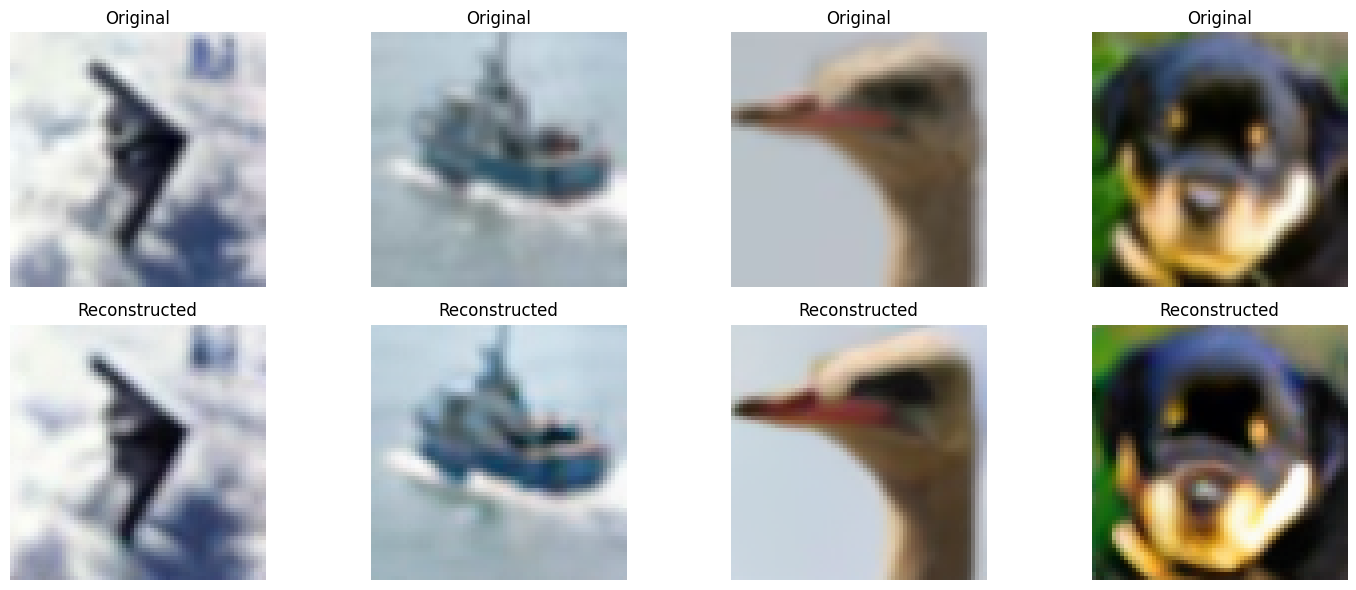

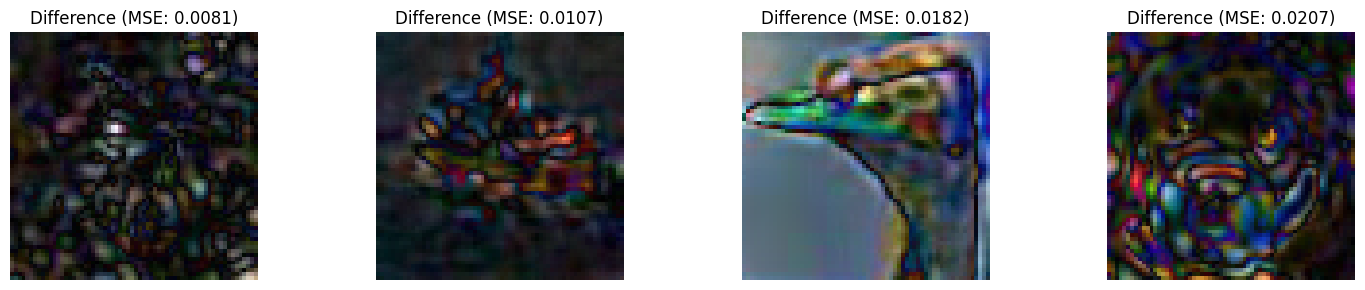

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Move tensors to CPU for visualization if they're on GPU
if images.device.type == 'cuda':
    images_cpu = images.detach().cpu()
    reconstructed_images_cpu = reconstructed_images.detach().cpu()
else:
    images_cpu = images.detach()
    reconstructed_images_cpu = reconstructed_images.detach()

# Function to convert from tensor format to displayable image
def tensor_to_image(tensor):
    # Convert from [-1, 1] range (if normalized) to [0, 1]
    img = (tensor + 1) / 2 if tensor.min() < 0 else tensor
    # Convert from [C, H, W] to [H, W, C] format for displaying
    return img.permute(1, 2, 0).numpy().clip(0, 1)

# Number of images to display
num_images = min(4, images_cpu.shape[0])  # Show at most 4 images

# Create a figure with subplots (2 rows: originals and reconstructions)
fig, axs = plt.subplots(2, num_images, figsize=(15, 6))

# Display original images on top row
for i in range(num_images):
    img = tensor_to_image(images_cpu[i])
    axs[0, i].imshow(img)
    axs[0, i].set_title('Original')
    axs[0, i].axis('off')

# Display reconstructed images on bottom row
for i in range(num_images):
    img = tensor_to_image(reconstructed_images_cpu[i])
    axs[1, i].imshow(img)
    axs[1, i].set_title('Reconstructed')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

# If you want to display image differences
fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
for i in range(num_images):
    # Calculate absolute difference
    diff = torch.abs(images_cpu[i] - reconstructed_images_cpu[i])
    diff_img = diff.detach().permute(1, 2, 0).numpy()
    
    # Normalize difference for better visibility
    if diff_img.max() > 0:
        diff_img = diff_img / diff_img.max()
    
    axs[i].imshow(diff_img)
    axs[i].set_title(f'Difference (MSE: {torch.mean((images_cpu[i] - reconstructed_images_cpu[i])**2):.4f})')
    axs[i].axis('off')

plt.tight_layout()
plt.show()